In [ ]:
!ls

base_code_1.png  drive	sample_data


I am using PyTorch as the main deep learning library and importing the necessary libraries. The dataset is in .CSV format and consists of user mobility time series data with Access Point (AP) IDs. There are a total of 5823 datasets, but since I'm splitting them into a training dataset and a test dataset in an 80:20 ratio, with a batch size of 100 and shuffling them using the random.shuffle function, the actual data I'm using consists of randomly shuffled 4600 training data and 1100 test data. Inside the CSV file, there are several integers listed.

For hyperparameters, I'm using 16 AP IDs, with 15 of them being used as model inputs, and the last AP ID as the output. Therefore, I set sequence_size to 15. Since it's a test-oriented training, I set epoch to 30 and chose an appropriate batch size of 100. As there are 12 APs in the dataset, I set the one-hot vector size to 12. I perform preprocessing based on these hyperparameters to shape the training data.

I'm using an LSTM as the training model with an input size of 1, a hidden layer size of 256, and a 3-layer structure. I'm using CrossEntropy as the loss function and Adam as the optimizer. I train on 80% of the pre-split dataset and evaluate on the remaining 20% to measure accuracy and loss. Finally, drawing the graph well.

I am using PyTorch as the main deep learning library and importing the necessary libraries. The dataset is in .CSV format and consists of user mobility time series data with Access Point (AP) IDs. There are a total of 5823 datasets, but since I'm splitting them into a training dataset and a test dataset in an 80:20 ratio, with a batch size of 100 and shuffling them using the random.shuffle function, the actual data I'm using consists of randomly shuffled 4600 training data and 1100 test data. Inside the CSV file, there are several integers listed.

For hyperparameters, I'm using 16 AP IDs, with 15 of them being used as model inputs, and the last AP ID as the output. Therefore, I set sequence_size to 15. Since it's a test-oriented training, I set epoch to 30 and chose an appropriate batch size of 100. As there are 12 APs in the dataset, I set the one-hot vector size to 12. I perform preprocessing based on these hyperparameters to shape the training data.

I'm using an LSTM as the training model with an input size of 1, a hidden layer size of 256, and a 3-layer structure. I'm using CrossEntropy as the loss function and Adam as the optimizer. I train on 80% of the pre-split dataset and evaluate on the remaining 20% to measure accuracy and loss. Finally, drawing the graph well.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Params
sequence_size = 15
epoch = 30
batch_size = 100
dataset_division_percentage = 80
total_dataset_count = 0
max_idx_value = 11
one_hot_vec_size = 12
sequence_file_path = './drive/MyDrive/MC23_data/*.csv'  # replace with your actual file path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load data
total_dataset = []
for csv_file in glob.glob(sequence_file_path):
    with open(csv_file, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for line in csv_reader:
            total_dataset.append(list(map(int, line)))

In [ ]:
np.random.shuffle(total_dataset)
total_dataset = np.array(total_dataset)
total_dataset_count = len(total_dataset)
training_dataset_count = int(total_dataset_count * dataset_division_percentage / 100)
test_dataset_count = total_dataset_count - training_dataset_count

In [ ]:
# Adjust the counts to be divisible by batch_size
training_dataset_count = (training_dataset_count // batch_size) * batch_size
test_dataset_count = (test_dataset_count // batch_size) * batch_size

In [ ]:
# Divide dataset into training and test datasets
train_dataset = total_dataset[:training_dataset_count]
test_dataset = total_dataset[training_dataset_count:training_dataset_count + test_dataset_count]

In [ ]:
# Print out the datasets' information
print(f'Total_dataset_count :: {total_dataset_count}')
print(f'Train&Test Ratio :: {dataset_division_percentage} : {100 - dataset_division_percentage}')
print(f'Train_dataset_count :: {len(train_dataset)}')
print(f'Test_dataset_count :: {len(test_dataset)}')

Total_dataset_count :: 5823
Train&Test Ratio :: 80 : 20
Train_dataset_count :: 4600
Test_dataset_count :: 1100


In [ ]:
# Pre-processing
def preprocess_data(dataset, sequence_size, one_hot_size):
    x_data = dataset[:, :sequence_size] / float(max_idx_value)
    y_data = np.eye(one_hot_size)[dataset[:, sequence_size]]
    x_data = x_data.reshape((x_data.shape[0], sequence_size, 1))
    return torch.FloatTensor(x_data), torch.LongTensor(y_data.argmax(axis=1))

In [ ]:
train_x, train_y = preprocess_data(train_dataset, sequence_size, one_hot_vec_size)
test_x, test_y = preprocess_data(test_dataset, sequence_size, one_hot_vec_size)

train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Define Model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Create Model, Loss function, Optimizer
model = Model(1, 256, 3, one_hot_vec_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Initialize lists to store loss and accuracy values
train_losses = []
val_accuracies = []

In [ ]:
# Training
start = time.time()
for e in range(epoch):
    model.train()
    epoch_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{e+1}/{epoch}], Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'Validation Accuracy of the model on test data: {val_accuracy}%')

print('Training complete in {:.0f}m {:.0f}s'.format((time.time() - start) // 60, (time.time() - start) % 60))


Epoch [1/30], Loss: 1.8325
Validation Accuracy of the model on test data: 35.27272727272727%
Epoch [2/30], Loss: 1.4524
Validation Accuracy of the model on test data: 36.72727272727273%
Epoch [3/30], Loss: 1.4036
Validation Accuracy of the model on test data: 36.90909090909091%
Epoch [4/30], Loss: 1.4048
Validation Accuracy of the model on test data: 37.09090909090909%
Epoch [5/30], Loss: 1.3891
Validation Accuracy of the model on test data: 37.63636363636363%
Epoch [6/30], Loss: 1.3813
Validation Accuracy of the model on test data: 38.36363636363637%
Epoch [7/30], Loss: 1.3801
Validation Accuracy of the model on test data: 37.90909090909091%
Epoch [8/30], Loss: 1.3619
Validation Accuracy of the model on test data: 37.72727272727273%
Epoch [9/30], Loss: 1.3545
Validation Accuracy of the model on test data: 38.90909090909091%
Epoch [10/30], Loss: 1.3387
Validation Accuracy of the model on test data: 38.72727272727273%
Epoch [11/30], Loss: 1.3337
Validation Accuracy of the model on test 

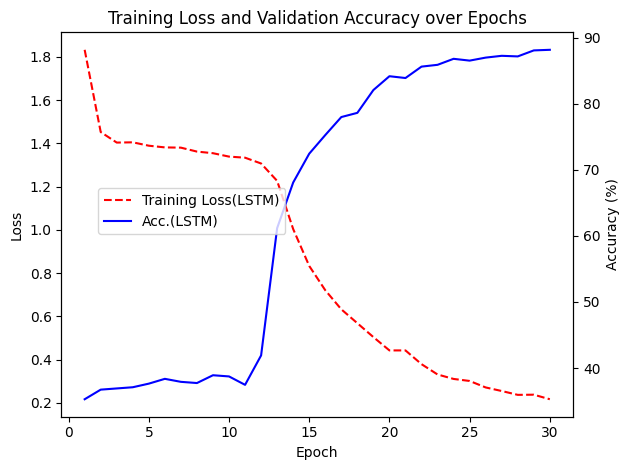

In [ ]:
# After training is complete, plot the training loss and validation accuracy
# Plotting
# plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+1), train_losses, label='Training Loss(LSTM)', linestyle='dashed', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Accuracy over Epochs')

# Creating a second y-axis for the validation accuracy
ax2 = plt.gca().twinx()
ax2.plot(range(1, epoch+1), val_accuracies, label='Acc.(LSTM)', color='b')
ax2.set_ylabel('Accuracy (%)')

# Adding legends
fig = plt.gca().figure
fig.legend(loc='center left', bbox_to_anchor = [0.15,0.55])

plt.tight_layout()
plt.savefig(
    "./base_code_1.png",
    dpi=500,
    edgecolor="white",
    bbox_inches="tight",
    pad_inches=0.1,
)


In [ ]:
# Define Model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, (h0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Params
sequence_size = 15
epoch = 30
batch_size = 100
dataset_division_percentage = 80
total_dataset_count = 0
max_idx_value = 11
one_hot_vec_size = 12

In [ ]:
# Create Model, Loss function, Optimizer
model = Model(1, 256, 6, one_hot_vec_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Initialize lists to store loss and accuracy values
train_losses_2 = []
val_accuracies_2 = []

In [ ]:
# Training
start = time.time()
for e in range(epoch):
    model.train()
    epoch_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses_2.append(epoch_loss)
    print(f'Epoch [{e+1}/{epoch}], Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_accuracies_2.append(val_accuracy)
        print(f'Validation Accuracy of the model on test data: {val_accuracy}%')

Epoch [1/30], Loss: 1.7195
Validation Accuracy of the model on test data: 35.90909090909091%
Epoch [2/30], Loss: 1.4246
Validation Accuracy of the model on test data: 37.45454545454545%
Epoch [3/30], Loss: 1.4074
Validation Accuracy of the model on test data: 36.45454545454545%
Epoch [4/30], Loss: 1.3876
Validation Accuracy of the model on test data: 35.72727272727273%
Epoch [5/30], Loss: 1.3819
Validation Accuracy of the model on test data: 37.09090909090909%
Epoch [6/30], Loss: 1.3471
Validation Accuracy of the model on test data: 39.81818181818182%
Epoch [7/30], Loss: 1.3473
Validation Accuracy of the model on test data: 36.18181818181818%
Epoch [8/30], Loss: 1.2757
Validation Accuracy of the model on test data: 59.09090909090909%
Epoch [9/30], Loss: 0.9519
Validation Accuracy of the model on test data: 69.0909090909091%
Epoch [10/30], Loss: 0.8011
Validation Accuracy of the model on test data: 73.18181818181819%
Epoch [11/30], Loss: 0.6953
Validation Accuracy of the model on test d

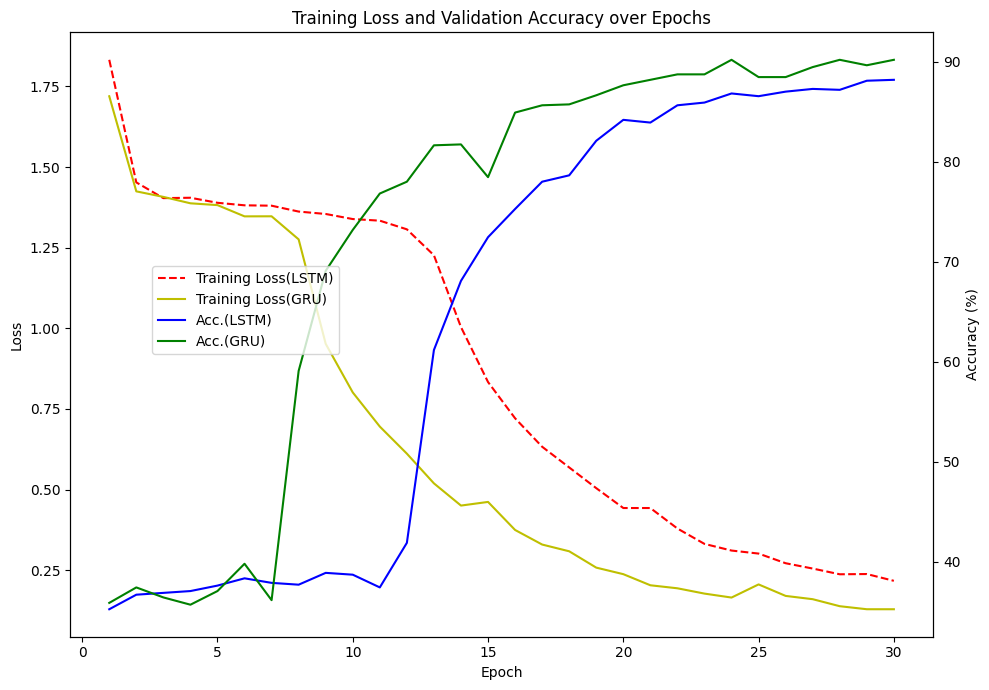

In [ ]:
# After training is complete, plot the training loss and validation accuracy
# Plotting
plt.figure(figsize=(10,7))
plt.plot(range(1, epoch+1), train_losses, label='Training Loss(LSTM)', linestyle='dashed', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Accuracy over Epochs')

ax2 = plt.gca()
ax2.plot(range(1, epoch+1),train_losses_2, label='Training Loss(GRU)', color='y')

# Creating a second y-axis for the validation accuracy
ax3 = plt.gca().twinx()
ax3.plot(range(1, epoch+1), val_accuracies, label='Acc.(LSTM)', color='b')
ax3.set_ylabel('Accuracy (%)')

ax4 = plt.gca()
ax4.plot(range(1, epoch+1), val_accuracies_2, label='Acc.(GRU)', color='g')



# Adding legends
fig = plt.gca().figure
fig.legend(loc='center left', bbox_to_anchor = [0.15,0.55])

plt.tight_layout()
plt.savefig(
    "./base_code_1.png",
    dpi=500,
    edgecolor="white",
    bbox_inches="tight",
    pad_inches=0.1,
)


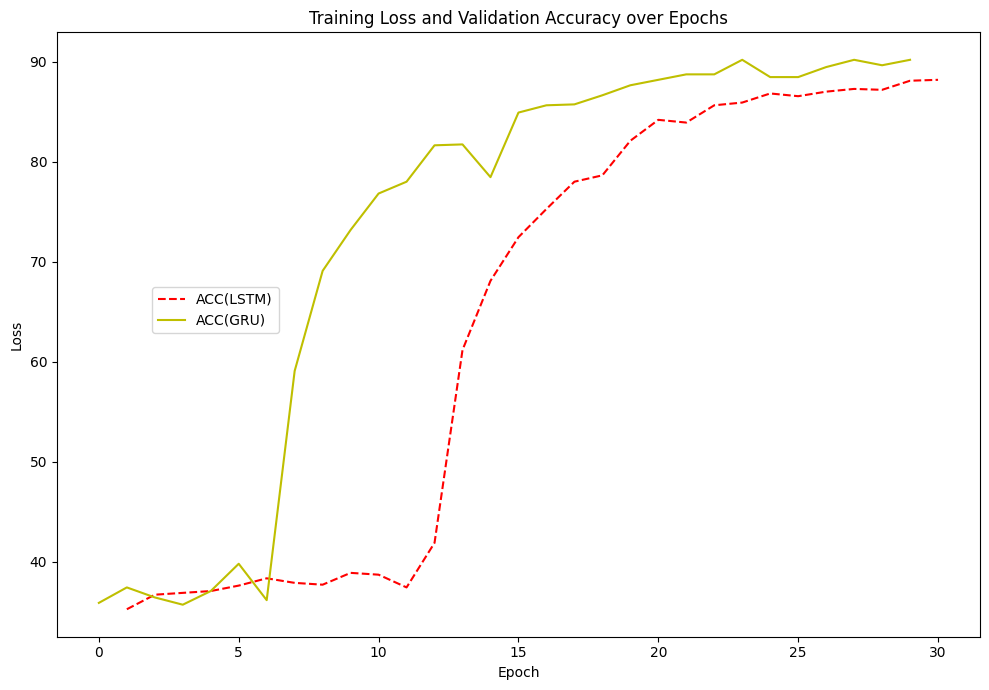

In [ ]:
# After training is complete, plot the training loss and validation accuracy
# Plotting
plt.figure(figsize=(10,7))
plt.plot(range(1, epoch+1), val_accuracies, label='ACC(LSTM)', linestyle='dashed', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Accuracy over Epochs')

ax2 = plt.gca()
ax2.plot(val_accuracies_2, label='ACC(GRU)', color='y')

# Creating a second y-axis for the validation accuracy
#ax3 = plt.gca().twinx()
#ax3.plot(range(1, epoch+1), val_accuracies, label='Acc.(LSTM)', color='b')
#ax3.set_ylabel('Accuracy (%)')

#ax4 = plt.gca()
#ax4.plot(range(1, epoch+1), val_accuracies_2, label='Acc.(GRU)', color='g')



# Adding legends
fig = plt.gca().figure
fig.legend(loc='center left', bbox_to_anchor = [0.15,0.55])

plt.tight_layout()
plt.savefig(
    "./base_code_1.png",
    dpi=500,
    edgecolor="white",
    bbox_inches="tight",
    pad_inches=0.1,
)
